#Practicando clasificadores con OpenCV.

> Autor: F.J. Madrid-Cuevas.

En este cuaderno vamos a realizar una práctica de clasifiación supervisada usando la librería OpenCV.

Quizás lo primero que tienes que hacer es repasar algo de la teoría de los clasificadores que vamos a practicar:

- [Nearest Neighbour (NN)](https://docs.opencv.org/3.4.12/d5/d26/tutorial_py_knn_understanding.html)

- [Support Vector Machines](https://docs.opencv.org/3.4.12/d1/d73/tutorial_introduction_to_svm.html)

- [Random Trees (RTrees)](https://docs.opencv.org/3.4/dc/dd6/ml_intro.html#ml_intro_rtrees)


#Carga de los módulos necesarios.
Lo primero que vamos a hacer es importar los paquetes que necesitamos:
- numpy para manipular arrays de datos.
- cv2 usar el clasificador SVM desde OpenCV
- matplotlib para poder representar gráficamente los resultados.


In [ ]:
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(0)

#Generar un Dataset para entrenar
Utilizando las utilizades que ofrece el módulo numpy vamos a generar nuestro dataset.

Vamos a poder crear dos versiones:
- uno que se puede separar linealmente.
- otro que no se puede separar linealmente.

Comenta/descomenta el código para seleccionar el tipo de dataset a generar. Te recomiendo que primero pruebes con el que se puede separar linealmente.

También puedes generar más clases, en este caso utiliza las etiquetas 2, 3, ... para cada una.
Otra cosa interesante a practicar es crear datasets con clases no balanceadas, es decir, hay significativamente más muestras de unas clases respecto a otras.

In [ ]:
def generate_distribution1(sigma, mu, size):
  '''
  Genera una distribución de puntos 2D siguiendo una distribución gaussina.
  '''
  dist = sigma*np.random.randn(size,2) + mu
  return dist.astype('f')

#Generar una distribución que no se podrá separar linealmente.
def generate_distribution2(c_x, c_y, sigma, mu, size):
  '''
  Genera una distribución de puntos en forma de anillo con un radio 
  que se distribuye según una gaussiana.
  '''
  rho = sigma*np.random.randn(size)+mu
  theta = (2.0*np.pi)*np.random.uniform(size=size)    
  dist = np.empty((size, 2), 'f')
  dist[:, 0] = c_x + np.multiply(rho, np.cos(theta))
  dist[:, 1] = c_y + np.multiply(rho, np.sin(theta))
  return dist.astype('f') #importante asegurar que nuestras muestras son CV_32F.

def split_dataset(samples, labels, train_fraction=0.8):
  '''
  Devide un conjunto de muestras y sus etiquetas en dos partes 
  para entrenar/validar o testear.
  '''
  size = samples.shape[0]
  indices = np.arange(samples.shape[0], dtype='i')
  np.random.shuffle(indices)
  train_indices = indices[:int(size*train_fraction)]
  test_indices = indices[int(size*train_fraction):]
  return samples[train_indices], labels[train_indices], samples[test_indices], labels[test_indices]

SAMPLES_PER_CLASE=500
#SIGMA = 0.75/3.0 #Con solape grado 0.
SIGMA = 1.25/3.0 #Con solape grado 1.
#SIGMA = 1.5/3.0 #Con solape grado 2.
#SIGMA = 1.75/3.0 #Con solape grado 3.

C0 = generate_distribution1(SIGMA, (1.0, 1.0), SAMPLES_PER_CLASE)
#C0 = generate_distribution2(0, 0, SIGMA, 1.0, SAMPLES_PER_CLASE)
C0_labels = 0*np.ones(C0.shape[0], 'i') #inportante las etiquetas son CV_32S

C1 = generate_distribution1(SIGMA, (2.0, 2.0), SAMPLES_PER_CLASE)
#C1 = generate_distribution2(0, 0, SIGMA, 2.0, SAMPLES_PER_CLASE)
C1_labels = 1*np.ones(C1.shape[0], 'i')

#Concatenamos todas las clases para generar el dataset.
samples = np.concatenate((C0, C1), axis=0)
labels = np.concatenate((C0_labels, C1_labels), axis=0)

#C2 = generate_distribution1(SIGMA, (1.0, 2.0), SAMPLES_PER_CLASE)
#C2 = generate_distribution2(3, 3, SIGMA, 1.0, SAMPLES_PER_CLASE)
#C2_labels = 2*np.ones(C2.shape[0], 'i')
#samples = np.concatenate((samples, C2), axis=0)
#labels = np.concatenate((labels, C2_labels), axis=0)

#C3 = generate_distribution1(SIGMA, (2.0, 1.0), SAMPLES_PER_CLASE)
#C3 = generate_distribution2(3, 3, SIGMA, 2.0, SAMPLES_PER_CLASE)
#C3_labels = 3*np.ones(C3.shape[0], 'i')
#samples = np.concatenate((samples, C3), axis=0)
#labels = np.concatenate((labels, C3_labels), axis=0)

##También puede añadir más clases. Usa etiquetas 4, 5, ...

#Creamos el subconjunto para entrenar y el subconjunto para validar.
Train_size=0.8 #80% train, 20%test
train_samples, train_labels, test_samples, test_labels = split_dataset(samples, 
                                                            labels, Train_size)


Ahora vamos a visualizar el dataset que hemos generado. Vamos a utilizar para visualizar el paquete *Matplotlib* [Ver aquí un tutorial básico.](https://pybonacci.org/2012/05/14/manual-de-introduccion-a-matplotlib-pyplot-i/)

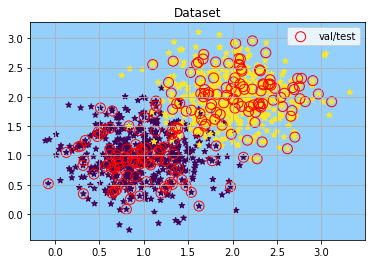

In [ ]:
#Visualizamos el dataset.
def show_dataset(X, y, X_test):
  '''
  Show a dataset of X samples with y labels. X_test are the samples used
  to validate/test the training.
  '''
  plt.clf()
  plt.title('Dataset')
  plt.grid('on')
  plt.gca().set_facecolor('xkcd:light blue')
  plt.scatter(X[:, 0], X[:, 1], c=y, marker='*')
  plt.scatter(X_test[:, 0], X_test[:, 1],
            s=100, linewidths=1, edgecolors='r', facecolors='none', 
            label='val/test')
  plt.legend()
  plt.show()

def plot_classifer_decision_function(samples, labels, clf, 
                                     positive_class, plot_support=False):
  '''
  Dibuja la superficie de clasificación con los vectores soporte
  para una clase dada.
  '''
  # create grid to evaluate model
  xmin = np.min(samples[:,0])
  ymin = np.min(samples[:,1])
  xmax = np.max(samples[:,0])
  ymax = np.max(samples[:,1])
  plt.clf()
  plt.title('SVM surface decision for class {}'.format(positive_class))
  plt.grid('on')
  plt.gca().set_facecolor('xkcd:light blue')
  x = np.linspace(xmin, xmax, 100)
  y = np.linspace(ymin, ymax, 100)
  Y, X = np.meshgrid(y, x)
  xy = np.vstack([X.ravel(), Y.ravel()]).T
  retv, P = clf.predict(xy.astype('f'))
  P = np.where(P==positive_class, 1, -1)
  P = P.reshape(X.shape)
  # plot decision boundary and margins
  plt.contour(X, Y, P, colors='k',
             levels=[-1, 0, 1], alpha=0.5,
             linestyles=['--', '-', '--'])  
  plt.scatter(samples[:,0], samples[:, 1], c=labels, marker='*')
  if plot_support and clf.__class__.__name__== 'ml_SVM':
    # plot support vectors
    svs = clf.getUncompressedSupportVectors()
    if not svs is None:
      print('Number of support vectors: {}'.format(svs.shape[0]))          
      plt.scatter(svs[:, 0], svs[:, 1],
                 s=100, linewidths=1, edgecolors='g', facecolors='none', label="Support vector")
      plt.legend()
  plt.show()  

show_dataset(samples, labels, test_samples)

# Definir una métrica.

Como ya sabemos, debemos definir una o varias métricas para medir el rendimiento del clasificador.

En este cuaderno vamos la utilizar la Exactitud ("Accuracy") del clasificador. Esta métrica se calcula a partir de la Matriz de Confusión. En [este enlace](https://en.wikipedia.org/wiki/Confusion_matrix) puedes repasar qué son y cómo se calculan.

In [ ]:
def compute_confusion_matrix(gts, preds):
  '''
  Calcula la matriz de confusión. Se asume que las etiquetas usandas
  son correlativas desde 0 hasta una etiqueta máxima y que almenos hay
  dos etiquetas.
  '''
  assert(len(gts)==len(preds))
  n_cats = int(np.max(gts)) + 1 #cuántas clases hay?
  assert(n_cats>1)
  cmat = np.zeros((n_cats, n_cats),'f') # El acuracy es la diagonal de la matriz principal, era 0 y dije 0, era 1 y dije 1, etc
  for idx in range(len(gts)):
      t = max(gts[idx], 0)
      p = max(preds[idx], 0)
      cmat[t, p] += 1.0
  return cmat

def compute_accuracy(cmat):
  '''
  Calcula la matriz Exactitud dada la matriz de confusión.
  '''
  acc = 0.0
  total = np.sum(cmat)
  if total>0.0:
    diag = np.sum(np.diag(cmat))
    acc = diag/total
  return acc

# Obtención de las particiones para Entrenamiento/Validación.

Ahora empieza un ciclo de entremiento del clasificador buscando los valores del los hiperparámetros óptimos. Para ello lo primero que haremos es dividir del conjunto de entrenamiento en dos partes una para entrenar y otra para validar el entrenamiento realizado.

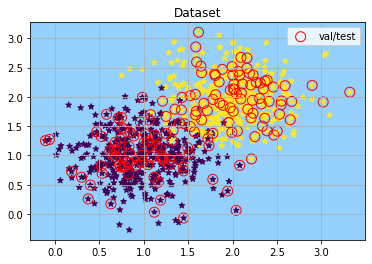

In [ ]:
TTrain_size = 0.8 #80% train, 20% validation
#Creamos el subconjunto para entrenar y el subconjunto para validar.
ttrain_samples, ttrain_labels, val_samples, val_labels = split_dataset(train_samples, 
                                                         train_labels, TTrain_size)

#vamos a mostrar los datos para entrenar y validar.
show_dataset(train_samples, train_labels, val_samples)

# Selección del clasificador a utilizar.

Además de la métrica, necesitamos elegir un clasificador. En este cuaderno vamos a comparar los clasifiadores K-NN, SVM y Random-Forest.

Vamos definir funciones para generar instancias de los clasifiadores a utilizar en este cuaderno. 

Recuerda que cada clasifiador tiene los siguientes hiper-parámetros:

- El clasificador K-NN sólo tiene el parámetro K (número de vecinos cercanos a usar).
- El clasificador SVM tiene además del hiperparámetro 'C', el tipo de kernel )(Linear, Polinómico, RBF) y cada tipo de kernel tiene a su vez sus parámetros: el grado del polinimio o el factor gamma para RBF.
- El clasificador Random-Forest tiene varios hiper parámetros, pero para este ejemplo tan simple, sólo vamos a utilizar sus valores por defecto.


(puede ser intersante leer la documentación de los clasificadores en el módulo [cv::ml](https://docs.opencv.org/3.4.16/dd/ded/group__ml.html)).

In [ ]:
def create_KNN_classifier(K=1):
  clf = cv2.ml.KNearest_create()
  clf.setIsClassifier(True)
  #Cambia aquí el número de vecinos usados para determinar la clase
  #de una nueva muestra.
  clf.setDefaultK(K)
  return clf

def create_SVM_classifier(C=1.0, Kernel=cv2.ml.SVM_LINEAR, param=None):
  clf = cv2.ml.SVM_create()
  clf.setType(cv2.ml.SVM_C_SVC)
  #El parámetro TermCriteria también sería un hiper-parámetro, pero nosotros
  #vamos a utilizar siempre el mismo valor.
  clf.setTermCriteria((cv2.TermCriteria_MAX_ITER, 10000, 1.0e-8))

  #El primer hiperparámetro a optimizar.
  clf.setC(C)

  clf.setKernel(Kernel)

  if Kernel==cv2.ml.SVM_POLY:
    #SVM con kernel polinómico.  
    clf.setDegree(param)

  if Kernel==cv2.ml.SVM_RBF:
    #SVM con kernel RBF    
    clf.setGamma(param)
  
  return clf

def create_RTrees_classifier():
  clf = cv2.ml.RTrees_create()
  # En este ejemplo usamos un dataset de jugete con sólo dos características, 
  # pocos muestras y pocas clases luego no tiene sentido cambiar los 
  # hiperparámetros: MaxCategories, MaxDepth, MinSampleCount, ActivateVarCount.   

  MAX_TREES=50
  MAX_OOB_ERROR=0.01
  term_crit = (cv2.TERM_CRITERIA_COUNT+cv2.TERM_CRITERIA_EPS, MAX_TREES, 
               MAX_OOB_ERROR)
  clf.setTermCriteria(term_crit)
  return clf

# Ciclo Entrenamiento / Validación.

Comenzamos un ciclo entrenamiento/validación para buscar la mejor posible configuración de clasificador e hiper-parámetros.

Vamos a definir dos listas para guardar la historia de valores de la métrica entre las distintas ejecuciones.

In [ ]:
acc_train = [] #historial de métrica en entrenamiento.
acc_val = [] #historial de métrica en validación.

## Paso 1. Instanciar el clasificador.
<a id='Paso1'></a>
El primer paso del ciclo, es crear una instancia del clasificador a utilizar fijando los valores de los hiperperámetros.

In [ ]:
#Elige qué clasificador quieres usar.
#clf = create_KNN_classifier(K=500) # Con k = 1, el modelo no tiene que decidir nada, cuando k > 1 puede equivocarse, tiene que elegir los k mas cercanos con mas probabilidad, por tanto no es 100% de probabilidad
clf = create_SVM_classifier(C=1, Kernel=cv2.ml.SVM_LINEAR, param=5)
#clf = create_RTrees_classifier()

print(clf)

<ml_SVM 0x7eff1c342850>


## Paso 2. Entrenamiento.
Ahora toca entrenar con los datos de entrenamiento. Observa que usaremos una parte del conjunto de entrenamiento (la otra la dejamos para validar).
También es interasante notar que usamos una muestra por cada fila de la matriz de muestras y esto lo indicamos con `cv2.ml.ROW_SAMPLE`.

In [ ]:
clf.train(ttrain_samples, cv2.ml.ROW_SAMPLE, ttrain_labels) # Si tengo 10k muestras y 50 clases, serian 10000 filas y 50 columnas

True

Vamos a ver cuál es la Exactitud en el entrenamiento.

Lo primero es clasificar, de nuevo, las muestras reservadas para entrenar.

In [ ]:
#importante las muestras son CV_32F
retv, predictions = clf.predict(ttrain_samples)
#esto hace que las predicciones sean un vector de enteros, no una matrix Nx1.
predictions = predictions.reshape(-1).astype('i')

# La prediccion con el conjuto de entrenamiento es 100% porque siempre sale lo que tiene que coger


Recuerda que vamos la utilizar la Exactitud como métrica. Para calcular esta métrica primero tenemos que calcular la matriz de confusión.

In [ ]:
#creamos la matriz de confusión.
cmat = compute_confusion_matrix(ttrain_labels, predictions)
print("Matriz de confusión")
print(cmat)
#mostramos el Accuracy.
acc = compute_accuracy(cmat)
print("Accuracy: {0:.3}".format(acc))
#guaramos el valor.
acc_train.append(acc)

Matriz de confusión
[[316.   9.]
 [  6. 309.]]
Accuracy: 0.977


En este punto si la métrica (Exactitud en nuestro caso) es mala, es posible que estemos en una situación de "under-fitting", es decir, el modelo (o hiper-parámetros) del clasificador no permite aprender el problema.

En ese caso, iremos al [Paso 1](#Paso1) para usar otro clasificador o buscar unos valores para los hiper-parámetros mejores.

## Paso 3. Validación.

Ahora toca validar el entrenamiento usando la partición reservada para validar. 

Observa que las muestras usadas para validar no han sido vistas por el clasificador cuando fue entrenado. 

Lo primero es clasificar las muestras reservadas para validar.

In [ ]:
#importante las muestras son CV_32F
retv, predictions = clf.predict(val_samples)
#esto hace que las predicciones sean un vector de enteros, no una matrix Nx1.
predictions = predictions.reshape(-1).astype('i') 

Recuerda que vamos la utilizar el Exactitud como métrica. Para calcular esta métrica primero tenemos que calcular la matriz de confusión.

In [ ]:
cmat = compute_confusion_matrix(val_labels, predictions)
print("Matriz de confusión")
print(cmat)
acc = compute_accuracy(cmat)
print("Accuracy: {0:.3}".format(acc))
#guaramos el valor.
acc_val.append(acc)

Matriz de confusión
[[74.  5.]
 [ 3. 78.]]
Accuracy: 0.95


Además podemos ver cual es la superficie de separación para cada clase. Actualiza la variable `positive_class` para indicar cuál es la clase positiva.

Number of support vectors: 73


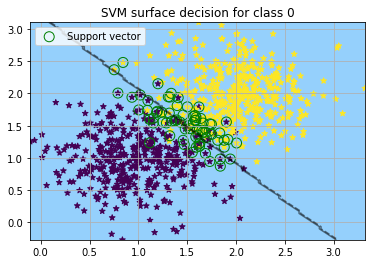

In [ ]:
positive_class = 0 # cambia esto para ver otras clases.
plot_classifer_decision_function(train_samples, train_labels,
                                 clf, positive_class, True)

Buscamos conseguir una Exactitud = 1.0. Si el resultado no es satisfactorio volveríamos al [Paso 1](#Paso1) para usar otra configuración de los  hiper-parámetros buscando obtener un mejor resultado. Al final nos quedaríamos con la configuración que mejor métrica de validación obtenga.

Veamos el historial de Train/Validación:

[]

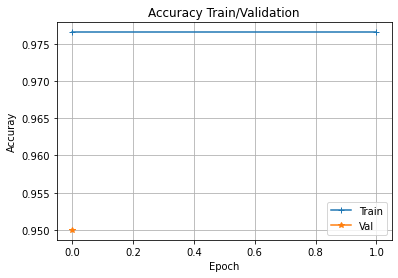

In [ ]:
plt.title("Accuracy Train/Validation")
plt.xlabel('Epoch')
plt.ylabel('Accuray')
plt.plot(np.arange(len(acc_train)), acc_train, '-+', label='Train')
plt.plot(np.arange(len(acc_val)), acc_val, '-*', label='Val')
plt.legend()
plt.grid(True)
plt.plot()

# Test

Una vez que ya hemos encontrado los hiperparámetros óptimos vamos a utilizar la partición reservada para el Test. Observa que los datos usados en esta partición no han sido vistos nunca por el clasificador ni para entrenar ni para validar.

Por lo tanto esta fase permite obtener una estimación de lo bien que nuestro clasificador puede generalizar el aprendizaje realizado al aplicarse a muestras nunca vistas. 

Debes tener encuenta que lo normal es que el valor de la métrica que obtendremos sea inferior a la major obtenida en la fase de entrenamiento. Ten encuenta que hemos "optimizado" el clasificador para los datos de entrenamiento y por lo tanto, hemos obtenido el mejor valor para ellos.

Además la partición de Test también se puede utilizar para comprobar si tus resultados son mejores o peores que la de otros competidores, supuesto que estos competidores tampoco han podido utilizar esta partición en su entrenamiento.

Vamos a ver qué resultados obtenemos:

In [ ]:
#importante las muestras son CV_32F
retv, predictions = clf.predict(test_samples)

#Convertir a vector de enteros.
predictions = predictions.reshape(-1).astype('i') 

cmat = compute_confusion_matrix(test_labels, predictions)
print("Matriz de confusión")
print(cmat)
acc = compute_accuracy(cmat)
print("Accuracy: {0:.3}".format(acc))

Matriz de confusión
[[90.  6.]
 [ 5. 99.]]
Accuracy: 0.945


# Ejercicios propuestos.

### Para el clasificador K-NN

1. Complica el caso fácil de separción lineal de dos clases de generando datasets que tengan solape (en distintos grados) y varias clases. Estudia los resultados variando el parámetro K ¿Cómo afecta esto a Accuracy en entrenamiento? ¿y en Test?. ¿Como varía la superficie de separación?

### Para el clasificador SVM

1. Complica el caso fácil de separción lineal de dos clases de generando datasets que tengan solape (en distintos grados) entre clases y estudia los resultados usando un Kernel lineal y variando C. ¿Cómo afecta esto a Acc en entreamiento? ¿y en Test?. ¿Como varía la superficie de separción? ¿y el margen?

2. Modifica el kernel en el ejercicio 1 para usar un kernel polinómico. Varia los hiperparámetros C y Degree. Responde a las misma preguntas que en el ejercicio 1.

3. Crea un ejemplo de Dataset que no se pueda separar linealmente. Estudia los kernels Lineal, Polinómico y RBF. Responde a las misma preguntas que en el ejercicio 1.

4. Prueba con ejemplos de datasets multi-clase.

5. Prueba con un Dataset no separable de forma lineal.

### Para el clasificador R-trees

1. Complica el caso fácil de separación lineal de dos clases de generando datasets que tengan solape (en distintos grados) y varias clases. Estudia los resultados variando los parámetros Número máximo de Rtrees y el error OOB. ¿Cómo afecta esto a Accuracy en entrenamiento? ¿y en Test?. ¿Como varía la superficie de separación?